# Portfolio Optimization

## Packages and Global Variables

In [31]:
# Import packages
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as sci_opt

In [32]:
# List of securities
original_funds = ['TECB', 'SCHE', 'SCHF', 'SCHV', 'SCHG', 'KOMP', 'MDYG', 'MDYV', 'SLYG', 'SLYV', 'OSMAX', 'USMV', 'SBSPX', 'VOO']
bdc_funds = ['ARCC', 'MAIN', 'CSWC', 'HTGC']
citi_growth_screener = ['FDMO', 'IDMO', 'QGRO', 'FTC', 'PWV', 'IMTM', 'TTAC', 'IVE', 'EQWL', 'DIA', 'IDHQ', 'MGV', 'VTV', 'DLN', 'HSCZ', 'HAWX', 'TTAI']
citi_top_performing_low_cost_screener = ['SVXY', 'DXJ', 'MLPR', 'DBJP', 'HEWJ', 'FLJH', 'DXJS', 'AMJ', 'AMUB', 'MLPB', 'AMLP', 'MLPA', 'LVHI', 'POCT', 'OCTW', 'ATMP']
securities = original_funds + bdc_funds + citi_growth_screener + citi_top_performing_low_cost_screener + ['^GSPC'] # S&P 500 ^GSPC must be listed last

# Proper Column Names for scenario metrics
scenario_metric_columns = ['Scenario', 'Period', 'Returns', 'Volatility', 'Sharpe Ratio', 'Portfolio Weights']

# Calculate the 1, 5 and 10 years parameters
periods = [1, 5, 10]

## Extract Historical Performance

### Select securities and check for amount of history available

In [33]:
# Init Dataframe
df_min_date = pd.DataFrame(columns=['Min Date'])

# Capture the closing price for each security and add to dataframe
for security in securities:
    min_date = min(yf.Ticker(security).history(period='max').index)
    min_date_df = pd.DataFrame([min_date], columns=['Min Date'])
    df_min_date = pd.concat([df_min_date, min_date_df], ignore_index=True)

df_min_date.index = securities  # Assign securities as index after appending all rows

# Calculate the date 10 years ago from today, making it timezone-aware to match the DataFrame's timezone
ten_years_ago = pd.Timestamp(datetime.now() - timedelta(days=365*10)).tz_localize('America/New_York')

# Add a new column to indicate if the 'Min Date' is over 10 years from today
df_min_date['Over 10 Years'] = df_min_date['Min Date'] < ten_years_ago

df_min_date

C:\Users\sean1\AppData\Local\Temp\ipykernel_43336\1262593796.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_min_date = pd.concat([df_min_date, min_date_df], ignore_index=True)


,Min Date,Over 10 Years
TECB,2020-01-13 00:00:00-05:00,False
SCHE,2010-01-14 00:00:00-05:00,True
SCHF,2009-11-03 00:00:00-05:00,True
SCHV,2009-12-15 00:00:00-05:00,True
SCHG,2010-01-04 00:00:00-05:00,True
KOMP,2018-10-23 00:00:00-04:00,False
MDYG,2005-11-15 00:00:00-05:00,True
MDYV,2005-11-15 00:00:00-05:00,True
SLYG,2000-10-02 00:00:00-04:00,True
SLYV,2000-10-02 00:00:00-04:00,True


### Pull from Yahoo Finance package historical data

In [34]:
# Init Dataframe
df = pd.DataFrame()

# Capture the adjusted closing price for each security and add to dataframe
for security in securities:
    if df_min_date.loc[security, 'Over 10 Years']:
        df[security] = yf.download(security, start='2014-01-01', end=datetime.now().date().strftime("%Y-%m-%d"))['Adj Close']
        
df.index = df.index.tz_localize('America/New_York') 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

### EDA

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2575 entries, 2014-01-02 00:00:00-05:00 to 2024-03-26 00:00:00-04:00
Data columns (total 36 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SCHE    2575 non-null   float64
 1   SCHF    2575 non-null   float64
 2   SCHV    2575 non-null   float64
 3   SCHG    2575 non-null   float64
 4   MDYG    2575 non-null   float64
 5   MDYV    2575 non-null   float64
 6   SLYG    2575 non-null   float64
 7   SLYV    2575 non-null   float64
 8   OSMAX   2575 non-null   float64
 9   USMV    2575 non-null   float64
 10  SBSPX   2575 non-null   float64
 11  VOO     2575 non-null   float64
 12  ARCC    2575 non-null   float64
 13  MAIN    2575 non-null   float64
 14  CSWC    2575 non-null   float64
 15  HTGC    2575 non-null   float64
 16  IDMO    2575 non-null   float64
 17  FTC     2575 non-null   float64
 18  PWV     2575 non-null   float64
 19  IVE     2575 non-null   float64
 20  EQWL    2575 non-null   fl

In [36]:
df.head()

,SCHE,SCHF,SCHV,SCHG,MDYG,MDYV,SLYG,SLYV,OSMAX,USMV,...,SVXY,DXJ,DBJP,HEWJ,DXJS,AMJ,AMLP,MLPA,ATMP,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02 00:00:00-05:00,18.038141,23.579514,30.855171,20.588076,31.882494,30.555964,35.346088,37.864624,21.830843,28.898746,...,132.229996,33.840809,26.286573,NaN,10.903045,22.327337,38.526028,42.492554,15.128536,1831.979980
2014-01-03 00:00:00-05:00,18.015394,23.579514,30.901054,20.551394,32.081692,30.743732,35.514286,38.037209,21.959063,28.890526,...,133.029999,33.942757,26.362700,NaN,10.958038,22.293196,38.460442,42.492554,15.094930,1831.369995
2014-01-06 00:00:00-05:00,17.856167,23.556669,30.847527,20.459661,31.798780,30.649855,35.159897,37.641685,21.986057,28.824766,...,134.619995,33.602917,26.120466,NaN,10.950707,22.263927,38.394840,42.439545,15.055717,1826.770020
2014-01-07 00:00:00-05:00,17.931990,23.655678,30.992821,20.629349,31.986410,30.857180,35.522289,38.030010,22.019800,28.989180,...,137.770004,33.888382,26.362700,NaN,11.035027,22.298073,38.416702,42.519066,15.078124,1837.880005
2014-01-08 00:00:00-05:00,17.878910,23.625216,30.931644,20.656872,32.006630,30.919788,35.460213,37.850250,22.033297,28.980965,...,137.539993,34.133064,26.452677,NaN,11.101016,22.117580,38.132465,42.280483,14.966103,1837.489990


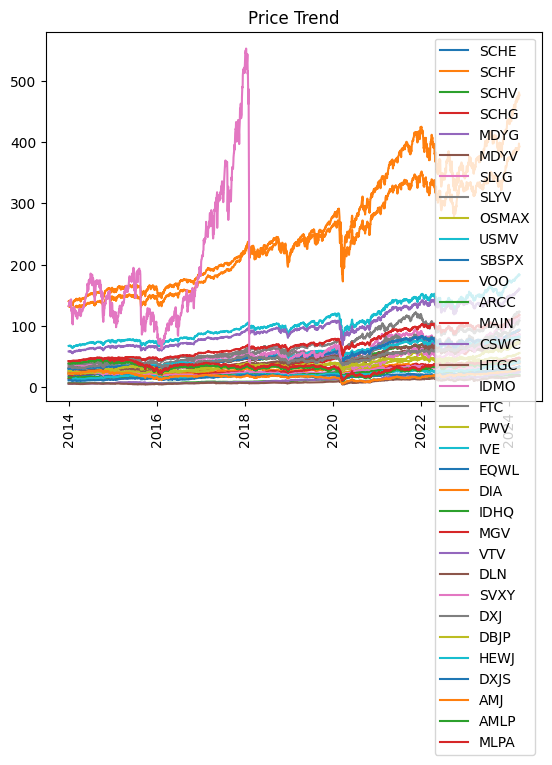

In [37]:
# Plot the close prices
plt.figure()
plt.plot(df.iloc[:,:-2]) # Excluded S&P 500 because of scale
plt.title('Price Trend')
plt.legend(df.columns)
plt.xticks(rotation=90)
plt.show()

### Correlations

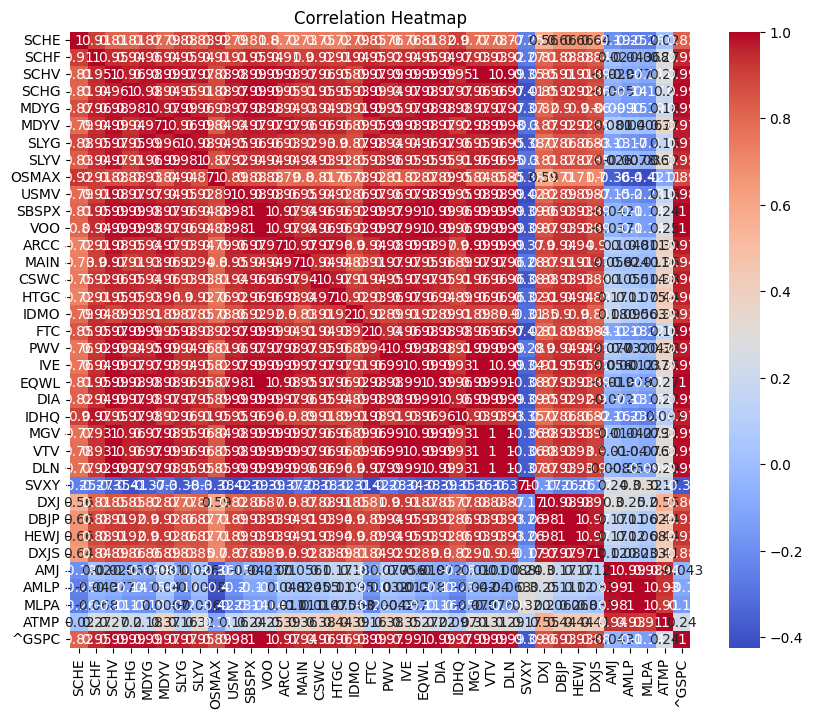

In [38]:
# Measure the correlation
import seaborn as sns

# Create a correlation matrix
corr_matrix = df.corr()

# Set the figure size
plt.figure(figsize=(10, 8))

# Create a heatmap using the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Set the title of the plot
plt.title('Correlation Heatmap')

# Show the plot
plt.show()



In [39]:
df.describe()

,SCHE,SCHF,SCHV,SCHG,MDYG,MDYV,SLYG,SLYV,OSMAX,USMV,...,SVXY,DXJ,DBJP,HEWJ,DXJS,AMJ,AMLP,MLPA,ATMP,^GSPC
count,2575.000000,2575.000000,2575.000000,2575.000000,2575.000000,2575.000000,2575.000000,2575.000000,2575.000000,2575.000000,...,2575.000000,2575.000000,2575.000000,2552.000000,2575.000000,2575.000000,2575.000000,2575.000000,2575.000000,2575.000000
mean,22.004873,28.238906,48.561531,44.568091,52.170872,47.902054,57.742263,56.875078,34.860462,53.029866,...,110.474819,49.438644,37.923761,21.459561,17.771710,18.122883,32.254499,35.127064,14.812253,3051.201607
std,3.626189,4.809032,12.445809,19.796982,14.747387,12.860590,16.836925,14.982137,9.183595,15.351023,...,95.971955,14.970935,10.270515,5.745209,4.723619,4.230603,6.753048,7.182185,3.121577,939.134010
min,13.685317,19.393904,29.172861,19.767122,30.511242,27.713686,32.416294,33.298428,20.555408,27.690174,...,26.270000,30.476431,22.985178,13.043578,9.990182,5.115896,9.864454,10.311749,4.879148,1741.890015
25%,19.283122,24.040907,36.559021,25.734838,37.802309,35.974617,40.810619,41.804113,25.369419,38.631622,...,51.900002,40.320089,30.980814,17.592241,14.105384,16.030827,29.238400,31.996760,13.374055,2131.170044
50%,22.151094,27.710747,46.716805,38.171299,50.327110,45.008072,56.453220,54.830364,35.858604,51.384239,...,66.419998,44.606438,35.364449,20.044491,17.540550,17.663267,32.565689,35.385803,14.697373,2818.370117
75%,23.991211,32.361345,62.174641,62.076296,66.619736,62.393822,72.523834,72.125053,40.543819,68.879517,...,132.195000,56.468302,45.332281,25.607072,20.183676,20.953501,36.334396,39.288275,16.946486,3957.439941
max,31.504093,39.009998,75.150002,93.320000,86.580002,74.830002,93.331573,85.785995,57.892090,82.900002,...,552.840027,109.209999,75.559998,42.360001,33.849998,28.370001,47.430000,48.493679,23.719999,5241.529785


## Calculate Sharpe Ratios

### Define Function will produce the pct change for the daily prices for each period

In [40]:
def period_pct_change(df, period=1):
    """
    This function filters the dataframe for the specified periods and return a dataframe with the pct_change applied to the daily price movements. 
    
    Parameters:
    - Period (int): Number of calendar years to extract. For example, if period is 5 and today is 3/20/2024 then the start_date us 1/1/2019 and end_date is 12/31/2023. 
    
    Returns:
    Dataframe with the pct change of the price for the specified period.
    """    
    # Get today's date
    today = pd.Timestamp(datetime.now()).tz_localize('America/New_York')
    
    # Calculate the start_date and end_date
    start_date = today.replace(year=today.year - period, month=1, day=1)
    end_date = today.replace(year=today.year - 1, month=12, day=31)
    
    # Filters for records between the start_date and end_date.
    pct_change_df = df.loc[start_date:end_date].pct_change()
            
    return np.log(1 + pct_change_df)

### Define Function to extract 1, 5, and 10 years performance

In [41]:
def calculate_metrics(period=1):
    """
    This function calculates the annualzed returns, volatility and sharpe ratios between the start and end dates.
    
    Parameters:
    - Period : Number of calendar years to extract. For example, if period is 5 and today is 3/20/2024 then the start_date us 1/1/2019 and end_date is 12/31/2023. 
    
    Returns:
    Dataframe with annualized return, volatility and sharpe ration for each security as a row
    """
    
    # Calculate Daily Simple returns
    daily_simple_returns = period_pct_change(df, period=period)

    # Calcuate the annualized returns
    annualized_returns = daily_simple_returns.mean() * 252 # 252 is the average number of trading days in a year

    # Calculate the Standard Deviation
    risk_std = daily_simple_returns.std() * np.sqrt(252)

    # Calculate the Sharpe Ratio
    sharpe_ratio = annualized_returns / risk_std

    # Combine the results
    simulations_data = [annualized_returns, risk_std, sharpe_ratio]

    # Create a DataFrame from it, then Transpose it so it looks like our original one.
    simulations_df = pd.DataFrame(data=simulations_data).T

    # Give the columns the Proper Names.
    simulations_df.columns = [item + "_" + str(period) for item in ['Returns', 'Volatility', 'Sharpe Ratio']]

    # Make sure the data types are correct, we don't want our floats to be strings.
    simulations_df = simulations_df.infer_objects()
    
    return simulations_df

### Call Function to get 1, 5 and 10 years metrics

In [42]:
# Init the dataframe to collect the resuld
simulations_df = pd.DataFrame()

# Create a loop to call the function to extract
for period in periods:
    if simulations_df.empty:
        simulations_df = calculate_metrics(period)
    else:
        simulations_df = simulations_df.merge(calculate_metrics(period), left_index=True, right_index=True, how='outer')
    
    
# Show the combined dataframe
simulations_df

,Returns_1,Volatility_1,Sharpe Ratio_1,Returns_5,Volatility_5,Sharpe Ratio_5,Returns_10,Volatility_10,Sharpe Ratio_10
AMJ,0.239461,0.144998,1.651478,0.100982,0.367179,0.275021,0.011223,0.314854,0.035645
AMLP,0.212328,0.157322,1.349637,0.080447,0.363759,0.221155,0.007860,0.310487,0.025315
ARCC,0.179332,0.172294,1.040850,0.148077,0.331100,0.447228,0.108963,0.256108,0.425455
ATMP,0.217308,0.145407,1.494485,0.098467,0.350796,0.280696,0.033747,0.309845,0.108916
CSWC,0.437139,0.203471,2.148406,0.156755,0.336510,0.465826,0.144700,0.279153,0.518353
DBJP,0.307017,0.155741,1.971324,0.136137,0.197641,0.688810,0.086043,0.203623,0.422560
DIA,0.150711,0.114272,1.318884,0.116132,0.209158,0.555237,0.104497,0.174912,0.597427
DLN,0.097671,0.115179,0.847994,0.116203,0.198455,0.585536,0.095992,0.164357,0.584046
DXJ,0.352191,0.164718,2.138152,0.157283,0.209190,0.751865,0.095734,0.209520,0.456921
DXJS,0.325015,0.163280,1.990541,0.125080,0.212512,0.588580,0.100847,0.208022,0.484792


### Define a plotting function

In [43]:
# Plot a scatter plot by the risk, return and sharpe ratios for each period
def plot_risk_return(period=1, ax=0):
    """
    Plot the risk rewards scatter plot with color code of the Sharpe ratio for all securities for the period provided.
    
    Parameters:
    period (int): Number of calendar years to extract. For example, if period is 5 and today is 3/20/2024 then the start_date us 1/1/2019 and end_date is 12/31/2023. This must match the periods list used in the calculate_metrics function
    
    Returns:
    Plots a scatter graph
    """
    
    # Check if period is in periods
    if period in periods: 
        # select the metrics for period
        period_metrics = [item + "_" + str(period) for item in ['Returns', 'Volatility', 'Sharpe Ratio']]
        
        # Return the Max Sharpe Ratio from the run.
        max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio' + "_" + str(period)].idxmax(), period_metrics]
        
        # Return the Min Volatility from the run.
        min_volatility = simulations_df.loc[simulations_df['Volatility' + "_" + str(period)].idxmin(), period_metrics]

        # S&P 500 Metrics
        sp500 = simulations_df.loc[simulations_df.index=='^GSPC', period_metrics]
        
        # Assuming simulations_df is defined elsewhere and accessible
        ax.scatter(y=simulations_df['Returns' + "_" + str(period)], x=simulations_df['Volatility' + "_" + str(period)], c=simulations_df['Sharpe Ratio' + "_" + str(period)], cmap='RdYlBu')

        # Corrected way to set titles and labels
        ax.set_title(f'Portfolio Returns Vs. Risk for the Last {period} Year(s)')
        # For colorbar, you typically need to capture the scatter plot as a variable and then create a colorbar with it
        scatter = ax.scatter(y=simulations_df['Returns' + "_" + str(period)], x=simulations_df['Volatility' + "_" + str(period)], c=simulations_df['Sharpe Ratio' + "_" + str(period)], cmap='RdYlBu')
        fig.colorbar(scatter, ax=ax, label='Sharpe Ratio')
        ax.set_xlabel('Standard Deviation')
        # If you also need to set the y-axis label, use:
        ax.set_ylabel('Returns')

        # Plot the Max Sharpe Ratio, using a `Blue Star`.
        ax.scatter(
            max_sharpe_ratio[1],
            max_sharpe_ratio[0],
            marker="x",
            color='b',
            s=50
        )
        ax.text(max_sharpe_ratio[1],
            max_sharpe_ratio[0],max_sharpe_ratio.name)


        # Plot the Min Volatility, using a `Red Star`.
        ax.scatter(
            min_volatility[1],
            min_volatility[0],
            marker="x",
            color='r',
            s=50
        )
        ax.text(min_volatility[1],
            min_volatility[0],min_volatility.name)

        # Plot the S&P 500, using a `Green Star`.
        ax.scatter(
            sp500.iloc[:,1],
            sp500.iloc[:,0],
            marker='x',
            color='g',
            s=50
        )
        ax.text(sp500.iloc[:,1],
            sp500.iloc[:,0],sp500.index.values[0])
        
        pass # End function

### Plot Risk vs Rewards Graphs for each period

C:\Users\sean1\AppData\Local\Temp\ipykernel_43336\2669593175.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[1],
C:\Users\sean1\AppData\Local\Temp\ipykernel_43336\2669593175.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[0],
C:\Users\sean1\AppData\Local\Temp\ipykernel_43336\2669593175.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(max_sharpe_ratio[1],
C:\Users\sean1\AppData\

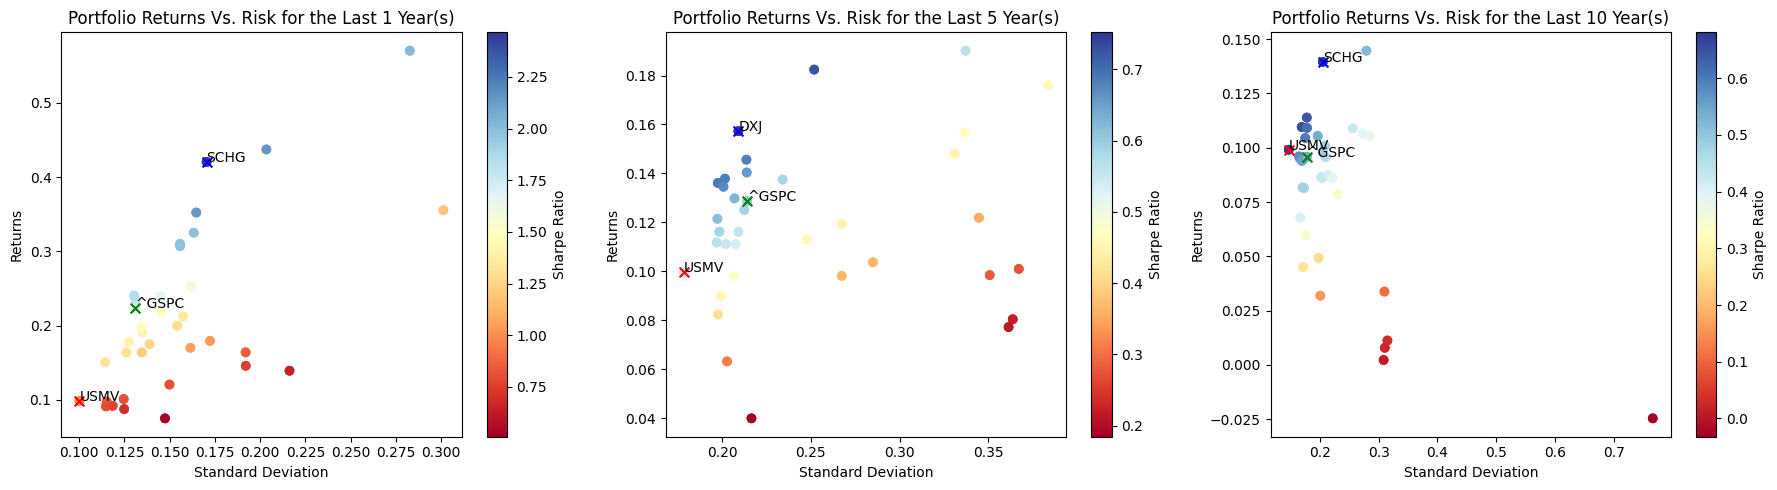

In [44]:
# Set up the figure and axes for a 1x3 grid
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot the Risk vs Returns plots for all periods in separate subplots
for i, period in enumerate(periods):
    ax = axes[i]
    plot_risk_return(period, ax=ax)  # Assuming plot_risk_return accepts an axis argument

plt.tight_layout()
plt.show()

### Plot the returns, volatility and sharpe for all securities by period

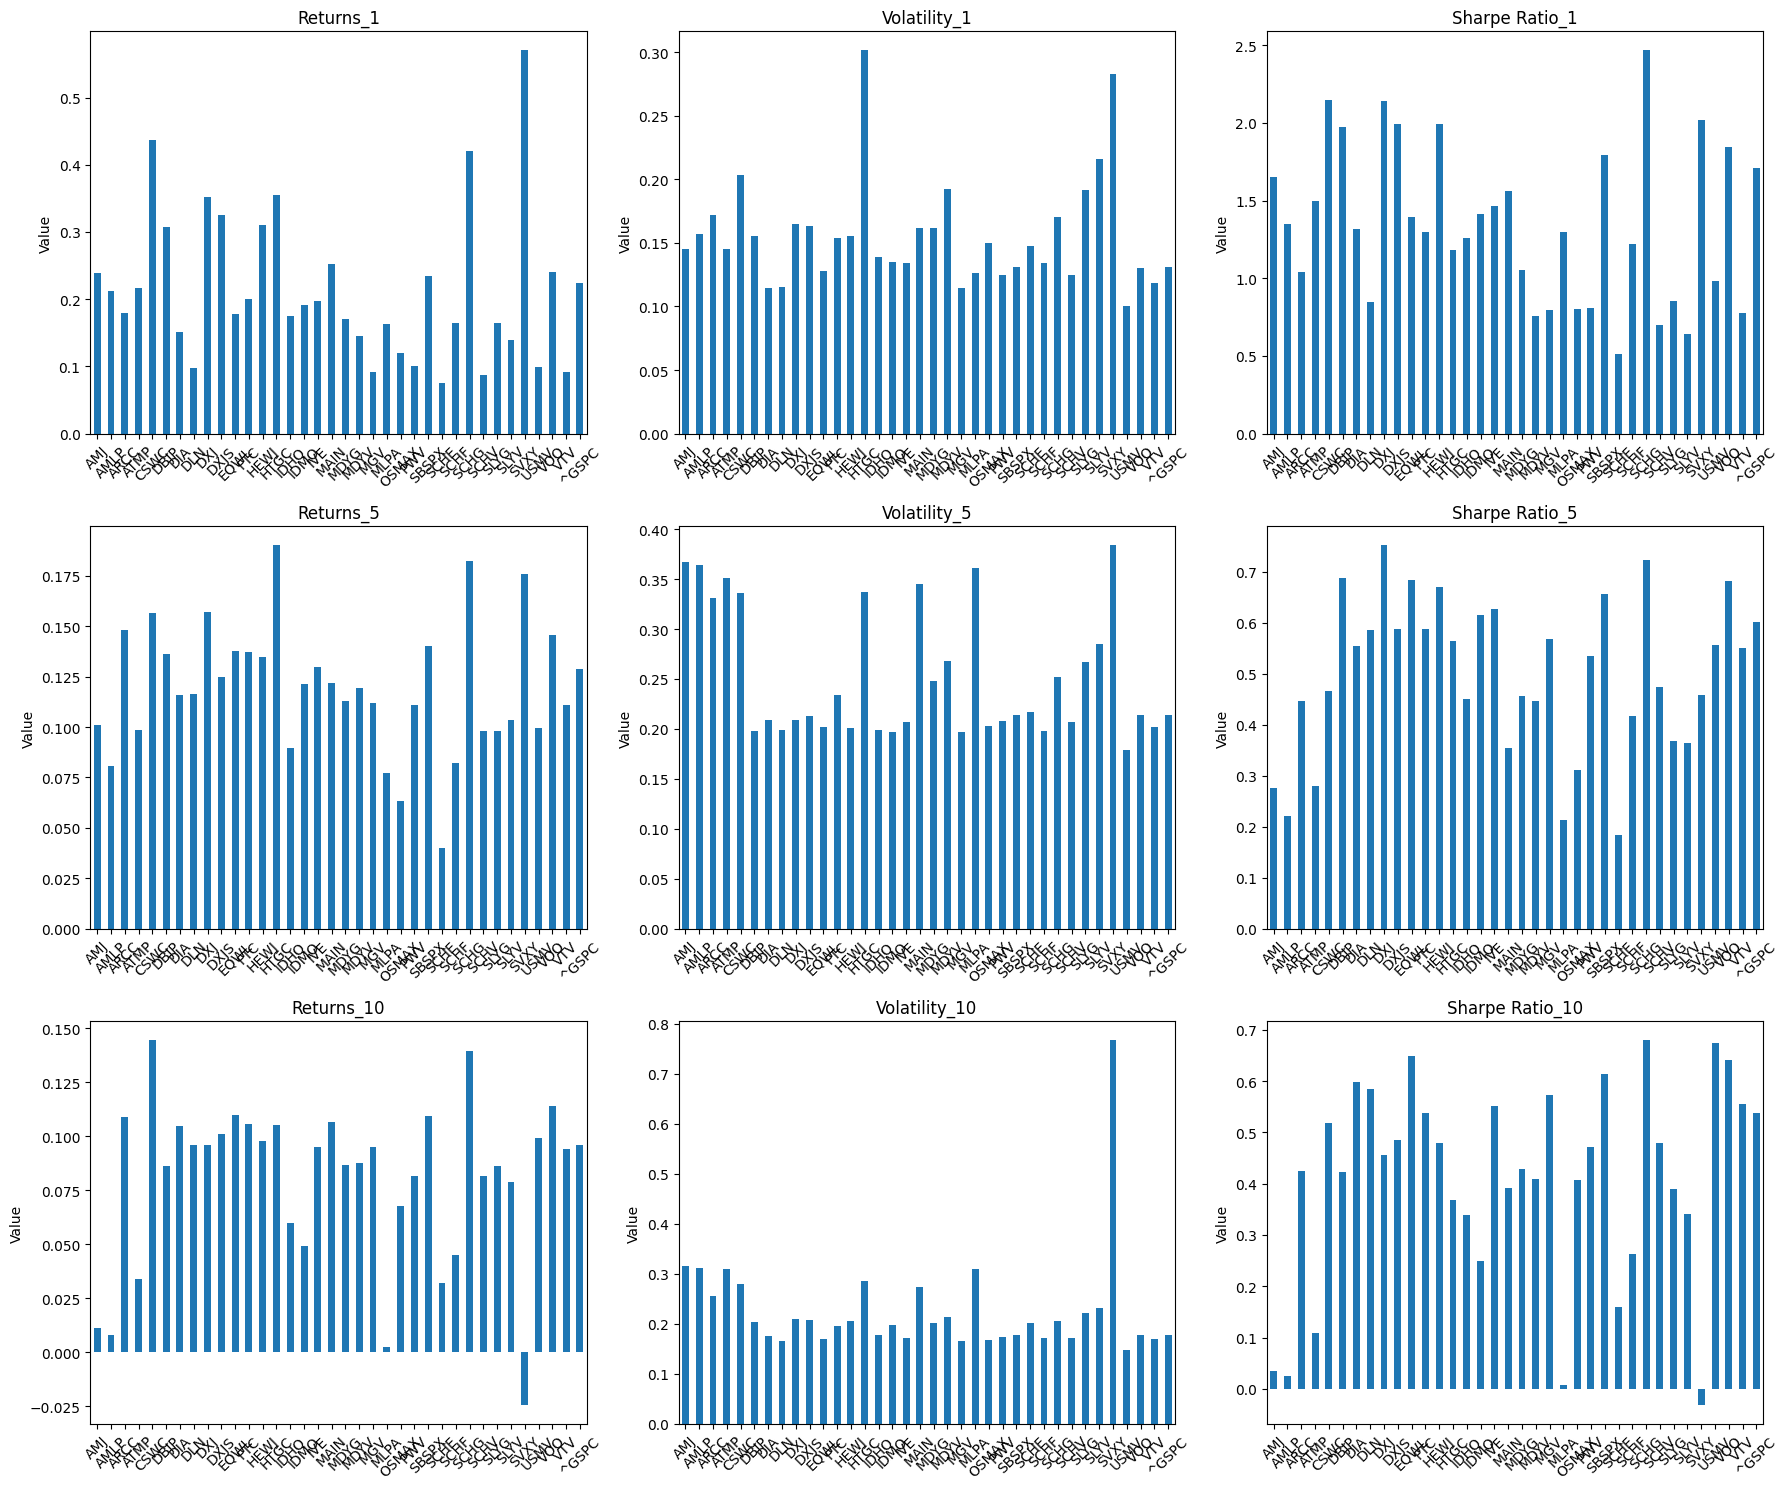

In [45]:
# Set up the figure and axes for a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Iterate over each column in simulations_df and create a bar plot in each subplot
for i, column in enumerate(simulations_df.columns):
    ax = axes_flat[i]
    simulations_df[column].plot(kind='bar', ax=ax)
    ax.set_title(column)
    ax.set_ylabel('Value')
    ax.tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

## Calculate Portfolio Expected Value
This code is from [Sigma Coding](https://www.youtube.com/c/SigmaCoding).
https://github.com/areed1192/portfolio-optimization.git

In [46]:
# Define portfolio only with ETFs
symbols = df.columns[:-2] # Drop the S&P 500 Index
price_data_frame = df[symbols]

# of symbols we have, so let's save some time and just calculate that now.
number_of_symbols = len(symbols)
print(f'The portfolio has {number_of_symbols} ETFs to select from.')



The portfolio has 34 ETFs to select from.


In [47]:
# Calculate the Log of returns.
#log_return = np.log(1 + price_data_frame.pct_change())
log_return = period_pct_change(price_data_frame, period=5) # Test without log


# Generate Random Weights.
random_weights = np.array(np.random.random(number_of_symbols))

# Generate the Rebalance Weights, these should equal 1.
rebalance_weights = random_weights / np.sum(random_weights)

# Calculate the Expected Returns, annualize it by multiplying it by `252`.
exp_ret = np.sum((log_return.mean() * rebalance_weights) * 252)

# Calculate the Expected Volatility, annualize it by multiplying it by `252`.
exp_vol = np.sqrt(
np.dot(
    rebalance_weights.T,
    np.dot(
        log_return.cov() * 252,
        rebalance_weights
    )
)
)

# Calculate the Sharpe Ratio.
sharpe_ratio = exp_ret / exp_vol

# Put the weights into a data frame to see them better.
weights_df = pd.DataFrame(data={
'random_weights': random_weights,
'rebalance_weights': rebalance_weights
})
print('')
print('='*80)
print('PORTFOLIO WEIGHTS:')
print('-'*80)
print(weights_df)
print('-'*80)

# Do the same with the other metrics.
metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

print('')
print('='*80)
print('PORTFOLIO METRICS:')
print('-'*80)
print(metrics_df)
print('-'*80)


PORTFOLIO WEIGHTS:
--------------------------------------------------------------------------------
    random_weights  rebalance_weights
0         0.599110           0.034069
1         0.754798           0.042923
2         0.315130           0.017920
3         0.753152           0.042829
4         0.375656           0.021362
5         0.950294           0.054040
6         0.792170           0.045048
7         0.634884           0.036104
8         0.741777           0.042182
9         0.415332           0.023619
10        0.049420           0.002810
11        0.188947           0.010745
12        0.824757           0.046901
13        0.759593           0.043196
14        0.163536           0.009300
15        0.722421           0.041082
16        0.200843           0.011421
17        0.530581           0.030172
18        0.507672           0.028870
19        0.876456           0.049841
20        0.815554           0.046378
21        0.533388           0.030332
22        0.563659       

## Portfolio Optimization

### Monte Carlo

#### Define function to run Monte Carlo simuations for the specified period.

In [48]:
def monte_carlo(period=1, num_of_portfolios=5000):
    """
    Run Monte Carlo portfolio simulation to identify the max Sharpe ratio and the Min Volatility scenarios for the specified period.     
    Parameters:
    - period (int): Number of calendar years to extract. For example, if period is 5 and today is 3/20/2024 then the start_date us 1/1/2019 and end_date is 12/31/2023. 
    - num_of_portfolios (int): The number of simulations to run. Default is 5000.
    
    Returns:
    2 Dataframes, max_sharpe_ratio and min_volatility containing the period, annualized return, volatility, Sharpe ratio and the weights for each security.
    """   

    
    # Initialize the components, to run a Monte Carlo Simulation.

    # Get the log_return by calling the period_pct_change function
    log_return = period_pct_change(price_data_frame, period)

    # Prep an array to store the weights as they are generated, 5000 iterations for each of our 4 symbols.
    all_weights = np.zeros((num_of_portfolios, number_of_symbols))

    # Prep an array to store the returns as they are generated, 5000 possible return values.
    ret_arr = np.zeros(num_of_portfolios)

    # Prep an array to store the volatilities as they are generated, 5000 possible volatility values.
    vol_arr = np.zeros(num_of_portfolios)

    # Prep an array to store the sharpe ratios as they are generated, 5000 possible Sharpe Ratios.
    sharpe_arr = np.zeros(num_of_portfolios)

    # Start the simulations.
    for ind in range(num_of_portfolios):

        # First, calculate the weights.
        weights = np.array(np.random.random(number_of_symbols))
        weights = weights / np.sum(weights)

        # Add the weights, to the `weights_arrays`.
        all_weights[ind, :] = weights

        # Calculate the expected log returns, and add them to the `returns_array`.
        ret_arr[ind] = np.sum((log_return.mean() * weights) * 252)

        # Calculate the volatility, and add them to the `volatility_array`.
        vol_arr[ind] = np.sqrt(
            np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
        )

        # Calculate the Sharpe Ratio and Add it to the `sharpe_ratio_array`.
        sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

    # Let's create our "Master Data Frame", with the weights, the returns, the volatility, and the Sharpe Ratio
    simulations_data = [np.full(num_of_portfolios, period), ret_arr, vol_arr, sharpe_arr, all_weights]

    # Create a DataFrame from it, then Transpose it so it looks like our original one.
    simulations_df = pd.DataFrame(data=simulations_data).T

    # Give the columns the Proper Names.
    simulations_df.columns = scenario_metric_columns[1:]
    
    # Make sure the data types are correct, we don't want our floats to be strings.
    simulations_df = simulations_df.infer_objects()

    # Return the Max Sharpe Ratio from the run.
    max_sharpe_ratio = pd.DataFrame(simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]).T # Select max sharpe scenario
    max_sharpe_ratio['Scenario'] = 'Monte Carlo Max Sharpe' # Assign Scenario name
    max_sharpe_ratio = max_sharpe_ratio[scenario_metric_columns] # Align columns in correct order

    # Return the Min Volatility from the run.
    min_volatility = pd.DataFrame(simulations_df.loc[simulations_df['Volatility'].idxmin()]).T # Select min volatility scenario
    min_volatility['Scenario'] = 'Monte Carlo Min Volatility' # Assign Scenario name
    min_volatility = min_volatility[scenario_metric_columns] # Align columns in correct order
    
    # This is so I can see the plot inside of my Jupyter Notebook.
    %matplotlib inline

    # Plot the data on a Scatter plot.
    plt.scatter(
        y=simulations_df['Returns'],
        x=simulations_df['Volatility'],
        c=simulations_df['Sharpe Ratio'],
        cmap='RdYlBu'
    )

    # Give the Plot some labels, and titles.
    plt.title(f'{period} Years Portfolio Returns Vs. Risk for {num_of_portfolios} scenarios')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Standard Deviation')
    plt.ylabel('Returns')

    # Plot the Max Sharpe Ratio, using a `Blue Star`.
    plt.scatter(
        max_sharpe_ratio['Volatility'],
        max_sharpe_ratio['Returns'],
        marker=(5, 1, 0),
        color='b',
        s=50
    )

    # Plot the Min Volatility, using a `Red Star`.
    plt.scatter(
        min_volatility['Volatility'],
        min_volatility['Returns'],
        marker=(5, 1, 0),
        color='r',
        s=50
    )

    # Finally, show the plot.
    plt.show()
    
    return max_sharpe_ratio, min_volatility

#### Call Monte Carlo for each period

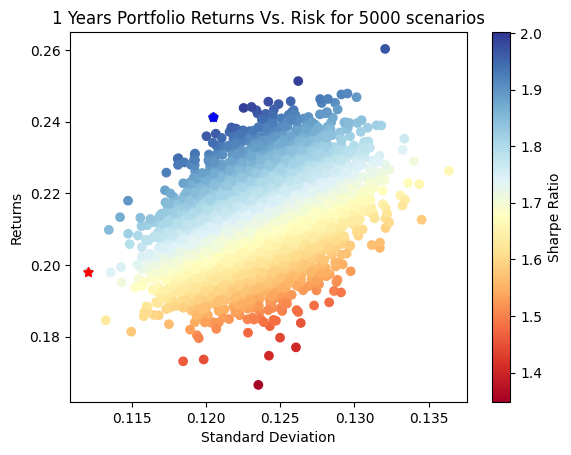

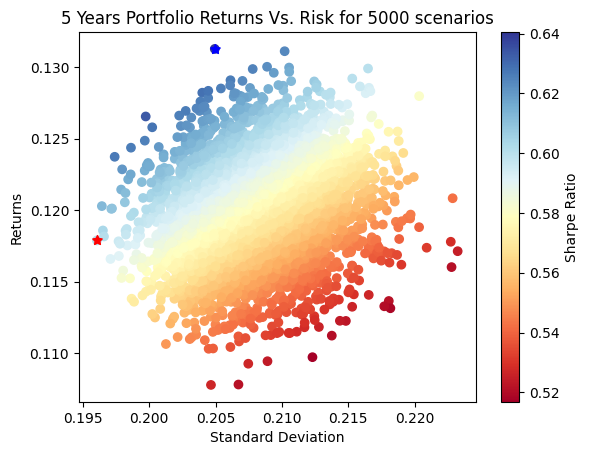

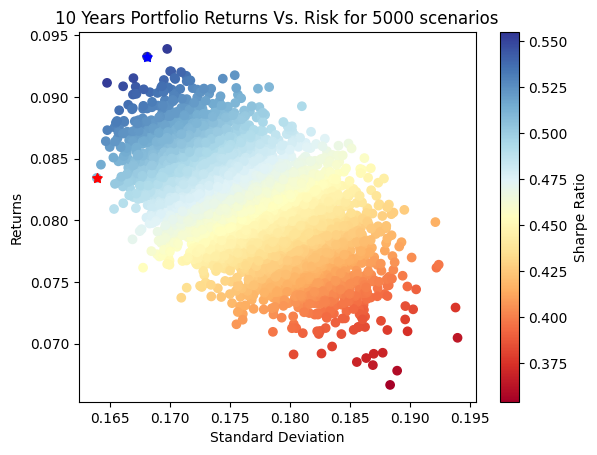


MAX SHARPE RATIO:
--------------------------------------------------------------------------------
                    Scenario Period   Returns Volatility Sharpe Ratio  \
1448  Monte Carlo Max Sharpe      1  0.241185   0.120507     2.001415   
689   Monte Carlo Max Sharpe      5  0.131268    0.20494     0.640518   
1077  Monte Carlo Max Sharpe     10  0.093271    0.16811     0.554823   

                                      Portfolio Weights  
1448  [0.012689050877792287, 0.03286723218315278, 0....  
689   [0.011990185217986248, 0.014254931909234712, 0...  
1077  [0.02764166270803068, 0.00227649371479239, 0.0...  
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
                        Scenario Period   Returns Volatility Sharpe Ratio  \
880   Monte Carlo Min Volatility      1  0.198014    0.11208     1.766728   
1283  Monte Carlo Min Volatility      5  0

In [49]:
# Init the dataframe to collect the result
max_sharpe_ratio = pd.DataFrame()
min_volatility = pd.DataFrame()

# Create a loop to call the function to extract
for period in periods:
    if max_sharpe_ratio.empty: # Assume that both datasets are empty
        max_sharpe_ratio, min_volatility = monte_carlo(period=period, num_of_portfolios=5000)
    else:
        max_sharpe_ratio_temp, min_volatility_temp = monte_carlo(period=period, num_of_portfolios=5000)
        max_sharpe_ratio = pd.concat([max_sharpe_ratio, max_sharpe_ratio_temp])
        min_volatility = pd.concat([min_volatility, min_volatility_temp])
    
    
# Show the combined dataframe
print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)

### Scipy Optimization

#### Define Functions

In [50]:
def get_metrics(weights: list) -> np.array:
    """
    ### Overview:
    ----
    With a given set of weights, return the portfolio returns,
    the portfolio volatility, and the portfolio sharpe ratio.

    ### Arguments:
    ----
    weights (list): An array of portfolio weights.

    ### Returns:
    ----
    (np.array): An array containg return value, a volatility value,
        and a sharpe ratio.
    """

    # Convert to a Numpy Array.
    weights = np.array(weights)

    # Calculate the returns, remember to annualize them (252).
    ret = np.sum(log_return.mean() * weights) * 252

    # Calculate the volatility, remember to annualize them (252).
    vol = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio.
    sr = ret / vol

    return np.array([ret, vol, sr])

def grab_negative_sharpe(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[2] * -1

def grab_volatility(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[1]

def check_sum(weights: list) -> float:
    """Ensure the allocations of the "weights", sums to 1 (100%)

    ### Arguments:
    ----
    weights (list): The weights we want to check to see
        if they sum to 1.

    ### Returns:
    ----
    float: The different between 1 and the sum of the weights.
    """
    return np.sum(weights) - 1

#### Define Max Sharpe Function

In [51]:
def optimized_sharpe(period=1):
    """
    Run Scipy Optimization to identify the max Sharpe ratio scenario for the specified period. 
    Parameters:
    - period (int): Number of calendar years to extract. For example, if period is 5 and today is 3/20/2024 then the start_date us 1/1/2019 and end_date is 12/31/2023. 
    
    Returns:
    Dataframe for max_sharpe_ratio containing the period, annualized return, volatility, Sharpe ratio and the weights for each security.
    """   
    
    
    # Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
    bounds = tuple((0, 1) for symbol in range(number_of_symbols))

    # Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
    constraints = ({'type': 'eq', 'fun': check_sum})

    # We need to create an initial guess to start with,
    # and usually the best initial guess is just an
    # even distribution. In this case 25% for each of the 4 stocks.
    init_guess = number_of_symbols * [1 / number_of_symbols]

    # Perform the operation to minimize the risk.
    optimized_sharpe = sci_opt.minimize(
        grab_negative_sharpe, # minimize this.
        init_guess, # Start with these values.
        method='SLSQP',
        bounds=bounds, # don't exceed these bounds.
        constraints=constraints # make sure you don't exceed the 100% constraint.
    )
    
    # Grab the metrics.
    optimized_max_sharpe_metrics = get_metrics(weights=optimized_sharpe.x)
    
    # Return Combined the metrics and weights into one data frame and return   
        # Return Combined the metrics and weights into one data frame and return   
    return pd.DataFrame([['Scipy Max Sharpe', period, optimized_max_sharpe_metrics[0], optimized_max_sharpe_metrics[1], optimized_max_sharpe_metrics[2], optimized_sharpe.x]], columns = scenario_metric_columns)

#### Define Min Volatility Function

In [52]:
def optimized_volatility(period=1):
    """
    Run Scipy Optimization to identify the min volatility scenario for the specified period. 
    Parameters:
    - period (int): Number of calendar years to extract. For example, if period is 5 and today is 3/20/2024 then the start_date us 1/1/2019 and end_date is 12/31/2023. 
    
    Returns:
    Dataframe for min_volatility containing the period, annualized return, volatility, Sharpe ratio and the weights for each security.
    """   
    
    # Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
    bounds = tuple((0, 1) for symbol in range(number_of_symbols))

    # Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
    constraints = ({'type': 'eq', 'fun': check_sum})

    # We need to create an initial guess to start with,
    # and usually the best initial guess is just an
    # even distribution. In this case 25% for each of the 4 stocks.
    init_guess = number_of_symbols * [1 / number_of_symbols]

    # Perform the operation to minimize the risk.
    optimized_volatility = sci_opt.minimize(
        grab_volatility, # minimize this.
        init_guess, # Start with these values.
        method='SLSQP',
        bounds=bounds, # don't exceed these bounds.
        constraints=constraints # make sure you don't exceed the 100% constraint.
    )

    # Grab the metrics.
    optimized_min_volatility_metrics = get_metrics(weights=optimized_volatility.x)
    
    # Return Combined the metrics and weights into one data frame and return   
    return pd.DataFrame([['Scipy Min Volatility', period, optimized_min_volatility_metrics[0], optimized_min_volatility_metrics[1], optimized_min_volatility_metrics[2], optimized_volatility.x]], columns = scenario_metric_columns)

#### Call functions for each period and capture the results

In [53]:
# Init the dataframe to collect the result
optimized_max_sharpe_metrics  = pd.DataFrame()
optimized_min_volatility_metrics = pd.DataFrame()

for period in periods:
    # Get the log_return by calling the period_pct_change function
    log_return = period_pct_change(price_data_frame, period)
    
    if optimized_max_sharpe_metrics.empty: # Assume that both datasets are empty 
        # Call optimized_sharpe
        optimized_max_sharpe_metrics = optimized_sharpe(period)
        # Call optimized_volatility
        optimized_min_volatility_metrics = optimized_volatility(period)
    else:
        # Call optimized_sharpe
        optimized_max_sharpe_metrics = pd.concat([optimized_max_sharpe_metrics, optimized_sharpe(period)], ignore_index=True)
        # Call optimized_volatility
        optimized_min_volatility_metrics = pd.concat([optimized_min_volatility_metrics, optimized_volatility(period)], ignore_index=True)
        
    
# Combine metrics
print(optimized_max_sharpe_metrics)
print(optimized_min_volatility_metrics)

           Scenario  Period   Returns  Volatility  Sharpe Ratio  \
0  Scipy Max Sharpe       1  0.372072    0.127294      2.922935   
1  Scipy Max Sharpe       5  0.169708    0.205727      0.824917   
2  Scipy Max Sharpe      10  0.123816    0.165552      0.747899   

                                   Portfolio Weights  
0  [0.0, 7.762284733532777e-17, 3.896522025592952...  
1  [0.0, 4.315733367767181e-16, 0.0, 0.3343692321...  
2  [0.0, 3.72281637082367e-16, 0.0, 0.36561170715...  
               Scenario  Period   Returns  Volatility  Sharpe Ratio  \
0  Scipy Min Volatility       1  0.135701    0.091034      1.490654   
1  Scipy Min Volatility       5  0.105071    0.169186      0.621034   
2  Scipy Min Volatility      10  0.089369    0.140559      0.635813   

                                   Portfolio Weights  
0  [0.0445848764190791, 0.0, 0.0, 3.8367204378830...  
1  [0.02391193113687446, 1.5178830414797062e-18, ...  
2  [1.493378081768332e-17, 0.0, 0.0, 0.0, 8.25424...  


## Evaluate Scenarios

### Combine all scenarios and extract the portfolio weights

In [54]:
# List the scenarios
scenarios = ['Monte Carlo Max Sharpe', 'Monte Carlo Min Volatility',  'Scipy Max Sharpe', 'Scipy Min Volatility']

# Combine all the scenarios into one dataframe for summary
df_portfolio_metrics_scenarios = pd.concat([max_sharpe_ratio.iloc[:,:5], min_volatility.iloc[:,:5], optimized_max_sharpe_metrics.iloc[:,:5], optimized_min_volatility_metrics.iloc[:,:5]], ignore_index=True)

# Extract the portfolio weights for each scenario and period
df_portfolio_weights_scenarios = pd.concat([max_sharpe_ratio[['Scenario', 'Period', 'Portfolio Weights']], min_volatility[['Scenario', 'Period', 'Portfolio Weights']], optimized_max_sharpe_metrics[['Scenario', 'Period', 'Portfolio Weights']], optimized_min_volatility_metrics[['Scenario', 'Period', 'Portfolio Weights']]], ignore_index=True).set_index(['Scenario', 'Period'])

# Expand the 'Portfolio Weights' lists into their own dataframe
weights_df = pd.DataFrame(df_portfolio_weights_scenarios['Portfolio Weights'].tolist(), columns=symbols, index=df_portfolio_weights_scenarios.index).reset_index()

# Join the expanded weights back with the original dataframe (if needed) or just work with the weights_df
df_portfolio_metrics_scenarios = df_portfolio_metrics_scenarios.merge(weights_df, on=['Scenario', 'Period'], how='inner')

### Calculate the current portfolio's expected returns, volatility and sharpe ratios

In [56]:
# Create new rows for the current portfolio allocation by assigning the weights
# ! Enhancement to create a dict for only those securities that are used for the current portfolio so that not entered multiple times and dynamic to match the symbols list.
new_rows = pd.DataFrame([
    {'Scenario': 'Current Portfolio', 'Period': 1, 'Returns': 0, 'Volatility': 0, 'Sharpe Ratio': 0, 
     'SCHE': 0, 'SCHF': 0, 'SCHV': 0, 'SCHG': 0.058, 'MDYG': 0, 'MDYV': 0, 'SLYG': 0, 'SLYV': 0, 'OSMAX': 0.12, 
     'USMV': 0.25, 'SBSPX': 0.56, 'VOO': 0, 'ARCC': 0, 'MAIN': 0, 'CSWC': 0, 'HTGC': 0, 'IDMO': 0, 'FTC': 0, 
     'PWV': 0, 'IVE': 0, 'EQWL': 0, 'DIA': 0, 'IDHQ': 0, 'MGV': 0, 'VTV': 0, 'DLN': 0, 'SVXY': 0, 'DXJ': 0, 
     'DBJP': 0, 'HEWJ': 0, 'DXJS': 0, 'AMJ': 0, 'AMLP': 0, 'MLPA': 0},
    {'Scenario': 'Current Portfolio', 'Period': 5, 'Returns': 0, 'Volatility': 0, 'Sharpe Ratio': 0, 
     'SCHE': 0, 'SCHF': 0, 'SCHV': 0, 'SCHG': 0.058, 'MDYG': 0, 'MDYV': 0, 'SLYG': 0, 'SLYV': 0, 'OSMAX': 0.12, 
     'USMV': 0.25, 'SBSPX': 0.56, 'VOO': 0, 'ARCC': 0, 'MAIN': 0, 'CSWC': 0, 'HTGC': 0, 'IDMO': 0, 'FTC': 0, 
     'PWV': 0, 'IVE': 0, 'EQWL': 0, 'DIA': 0, 'IDHQ': 0, 'MGV': 0, 'VTV': 0, 'DLN': 0, 'SVXY': 0, 'DXJ': 0, 
     'DBJP': 0, 'HEWJ': 0, 'DXJS': 0, 'AMJ': 0, 'AMLP': 0, 'MLPA': 0},
    {'Scenario': 'Current Portfolio', 'Period': 10, 'Returns': 0, 'Volatility': 0, 'Sharpe Ratio': 0, 
     'SCHE': 0, 'SCHF': 0, 'SCHV': 0, 'SCHG': 0.058, 'MDYG': 0, 'MDYV': 0, 'SLYG': 0, 'SLYV': 0, 'OSMAX': 0.12, 
     'USMV': 0.25, 'SBSPX': 0.56, 'VOO': 0, 'ARCC': 0, 'MAIN': 0, 'CSWC': 0, 'HTGC': 0, 'IDMO': 0, 'FTC': 0, 
     'PWV': 0, 'IVE': 0, 'EQWL': 0, 'DIA': 0, 'IDHQ': 0, 'MGV': 0, 'VTV': 0, 'DLN': 0, 'SVXY': 0, 'DXJ': 0, 
     'DBJP': 0, 'HEWJ': 0, 'DXJS': 0, 'AMJ': 0, 'AMLP': 0, 'MLPA': 0},
])

# Create a loop for each period
for period in periods:  
    # Extract from simulations_df the period
    returns = simulations_df[:-2].T.loc['Returns_'+str(period)]
    volatility = simulations_df[:-2].T.loc['Volatility_'+str(period)]
    weights = new_rows[new_rows['Period']==period].iloc[:,5:].T
    
    # Calculate the sum product of returns and weights
    sum_product_returns = (returns * weights.squeeze()).sum()
    
    # Update the 'Returns' column in the new_rows dataframe
    new_rows.loc[new_rows['Period'] == period, 'Returns'] = sum_product_returns
    
    # Assuming similar calculation for 'Volatility' if needed here
    sum_product_volatility = (volatility * weights.squeeze()).sum()
    new_rows.loc[new_rows['Period'] == period, 'Volatility'] = sum_product_volatility

# Calculate the Sharpe Ratio
new_rows['Sharpe Ratio'] = new_rows['Returns'] / new_rows['Volatility']

# Append the new rows to the dataframe
df_portfolio_metrics_scenarios = pd.concat([df_portfolio_metrics_scenarios, new_rows], ignore_index=True)

# Show scenario results
df_portfolio_metrics_scenarios.round(4)

C:\Users\sean1\AppData\Local\Temp\ipykernel_43336\272020145.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.19500266231907679' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_rows.loc[new_rows['Period'] == period, 'Returns'] = sum_product_returns
C:\Users\sean1\AppData\Local\Temp\ipykernel_43336\272020145.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.12632042339057187' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_rows.loc[new_rows['Period'] == period, 'Volatility'] = sum_product_volatility


,Scenario,Period,Returns,Volatility,Sharpe Ratio,SCHE,SCHF,SCHV,SCHG,MDYG,...,VTV,DLN,SVXY,DXJ,DBJP,HEWJ,DXJS,AMJ,AMLP,MLPA
0,Monte Carlo Max Sharpe,1,0.241185,0.120507,2.001415,0.0127,0.0329,0.0115,0.0554,0.0428,...,0.0160,0.0094,0.0348,0.0601,0.0260,0.0484,0.0533,0.0111,0.0266,0.0094
1,Monte Carlo Max Sharpe,5,0.131268,0.20494,0.640518,0.0120,0.0143,0.0044,0.0566,0.0163,...,0.0001,0.0701,0.0700,0.0605,0.0382,0.0459,0.0327,0.0021,0.0098,0.0233
2,Monte Carlo Max Sharpe,10,0.093271,0.16811,0.554823,0.0276,0.0023,0.0036,0.0470,0.0470,...,0.0280,0.0348,0.0056,0.0461,0.0483,0.0405,0.0239,0.0194,0.0015,0.0144
3,Monte Carlo Min Volatility,1,0.198014,0.11208,1.766728,0.0014,0.0317,0.0113,0.0273,0.0227,...,0.0067,0.0561,0.0011,0.0134,0.0135,0.0693,0.0687,0.0069,0.0057,0.0672
4,Monte Carlo Min Volatility,5,0.117885,0.196063,0.601262,0.0436,0.0429,0.0307,0.0525,0.0032,...,0.0056,0.0573,0.0124,0.0374,0.0333,0.0615,0.0460,0.0059,0.0060,0.0390
5,Monte Carlo Min Volatility,10,0.083436,0.16392,0.509002,0.0546,0.0063,0.0394,0.0050,0.0065,...,0.0031,0.0373,0.0033,0.0126,0.0552,0.0318,0.0398,0.0567,0.0052,0.0028
6,Scipy Max Sharpe,1,0.372072,0.127294,2.922935,0.0000,0.0000,0.0000,0.3790,0.0000,...,0.0000,0.0000,0.0000,0.0728,0.0000,0.0000,0.2074,0.1478,0.0000,0.0000
7,Scipy Max Sharpe,5,0.169708,0.205727,0.824917,0.0000,0.0000,0.0000,0.3344,0.0000,...,0.0000,0.0000,0.0000,0.5219,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,Scipy Max Sharpe,10,0.123816,0.165552,0.747899,0.0000,0.0000,0.0000,0.3656,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0471,0.0000,0.0000,0.0000
9,Scipy Min Volatility,1,0.135701,0.091034,1.490654,0.0446,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0735,0.0000,0.0000,0.2558


### Plot the Scenario Risk and Rewards by Period

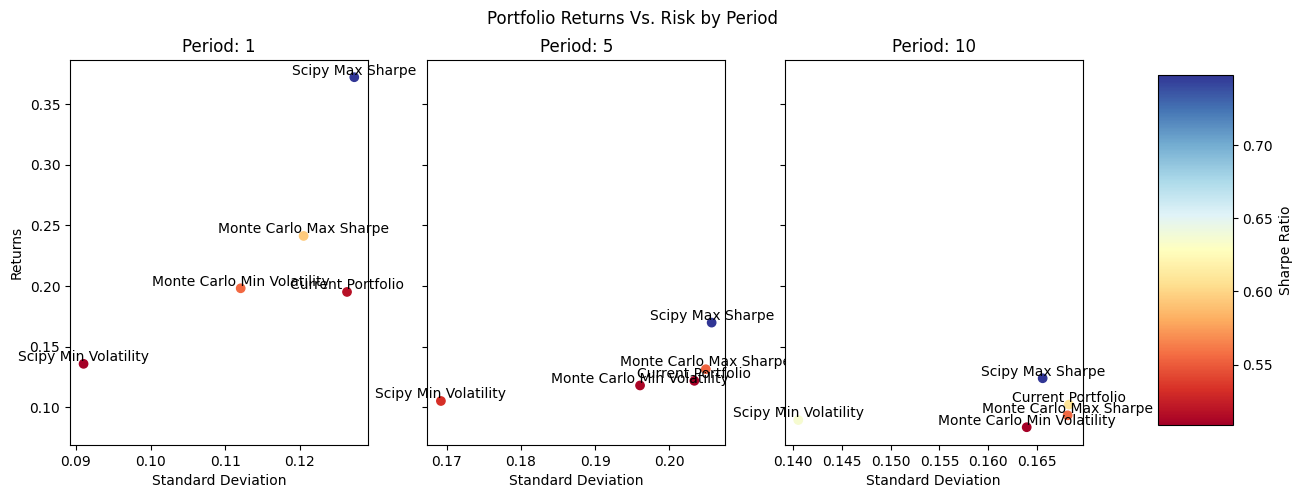

In [57]:
num_periods = len(periods)

fig, axs = plt.subplots(1, num_periods, figsize=(5*num_periods, 5), sharey=True)

for i, period in enumerate(periods):
    # Filter the dataframe for the current period
    df_period = df_portfolio_metrics_scenarios[df_portfolio_metrics_scenarios['Period'] == period]
    
    # Plotting
    sc = axs[i].scatter(data=df_period, x='Volatility', y='Returns', c='Sharpe Ratio', cmap='RdYlBu')
    
    # Adding text labels
    for index, row in df_period.iterrows():
        axs[i].text(row['Volatility'], row['Returns'], row['Scenario'], va='bottom', ha='center')
    
    # Setting titles and labels
    axs[i].set_title(f'Period: {period}')
    axs[i].set_xlabel('Standard Deviation')
    if i == 0:  # Only add y label to the first subplot to avoid repetition
        axs[i].set_ylabel('Returns')

# Adjusting the layout to make room for the colorbar
fig.subplots_adjust(right=0.8)

# Adding a colorbar
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])  # This adds a new axis for the colorbar
fig.colorbar(sc, cax=cbar_ax, orientation='vertical', label='Sharpe Ratio')

plt.suptitle('Portfolio Returns Vs. Risk by Period')
plt.show()

### Plot the Portfolio Allocation for scenarios by periods

C:\Users\sean1\AppData\Local\Temp\ipykernel_43336\4045807162.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(df_period.columns[1:], rotation=90)
C:\Users\sean1\AppData\Local\Temp\ipykernel_43336\4045807162.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(df_period.columns[1:], rotation=90)
C:\Users\sean1\AppData\Local\Temp\ipykernel_43336\4045807162.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(df_period.columns[1:], rotation=90)


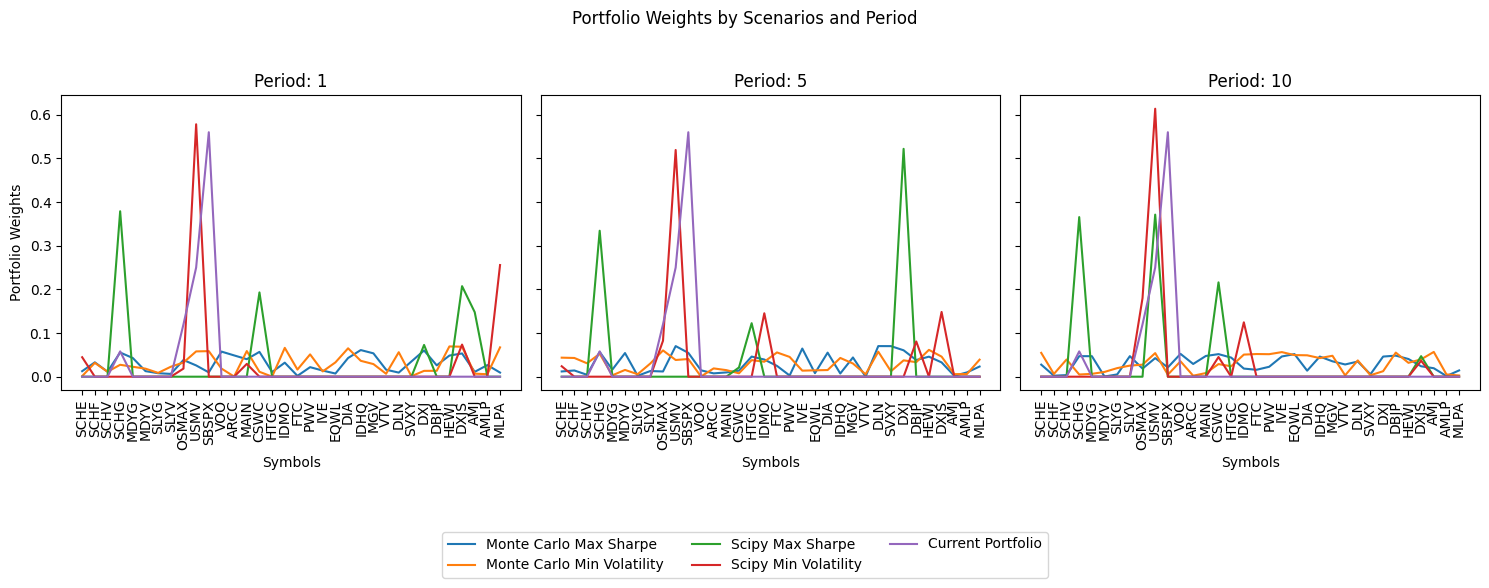

In [58]:
num_periods = len(periods)
fig, axs = plt.subplots(1, num_periods, figsize=(5*num_periods, 5), sharey=True)

lines = []  # To store the line objects for the legend
labels = []  # To store the labels for the legend

for i, period in enumerate(periods):
    # Filter the dataframe for the current period
    df_period = df_portfolio_metrics_scenarios[df_portfolio_metrics_scenarios['Period'] == period]
    df_period = df_period.drop(['Period', 'Returns', 'Volatility', 'Sharpe Ratio'], axis=1)
    
    # Assuming the first column is 'Scenario' and the rest are portfolio weights
    # Plot and collect line objects for legend
    lines += axs[i].plot(df_period.iloc[:, 1:].T)
    axs[i].set_title(f'Period: {period}')
    axs[i].set_xlabel('Symbols')
    axs[i].set_xticklabels(df_period.columns[1:], rotation=90)
    if i == 0:  # Only add y label to the first subplot to avoid repetition
        axs[i].set_ylabel('Portfolio Weights')
    
    # Collecting scenario names for legend
    if i == 0:  # Assuming scenario names are the same for all periods, so only do this once
        labels = df_period['Scenario'].unique()

# Placing one legend below the plots
fig.legend(lines[:len(labels)], labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

plt.suptitle('Portfolio Weights by Scenarios and Period')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the legend
plt.show()

### Review the correlation of the Max Scipy Sharpe investments with >1% allocation

In [59]:
# Select a list of securities fr the Max Scipy Sharpe with an allocation weight greater than 0.01
scipy_max_sharpe_securities = df_portfolio_metrics_scenarios.loc[df_portfolio_metrics_scenarios['Scenario']=='Scipy Max Sharpe'].iloc[:,5:].columns[(df_portfolio_metrics_scenarios.loc[df_portfolio_metrics_scenarios['Scenario']=='Scipy Max Sharpe'].iloc[:,5:] > 0.01).any()]

print(f"These securities, {scipy_max_sharpe_securities}, are selected for the Scipy Max Sharpe scenario for all periods.")

These securities, Index(['SCHG', 'USMV', 'CSWC', 'HTGC', 'DXJ', 'DXJS', 'AMJ'], dtype='object'), are selected for the Scipy Max Sharpe scenario for all periods.


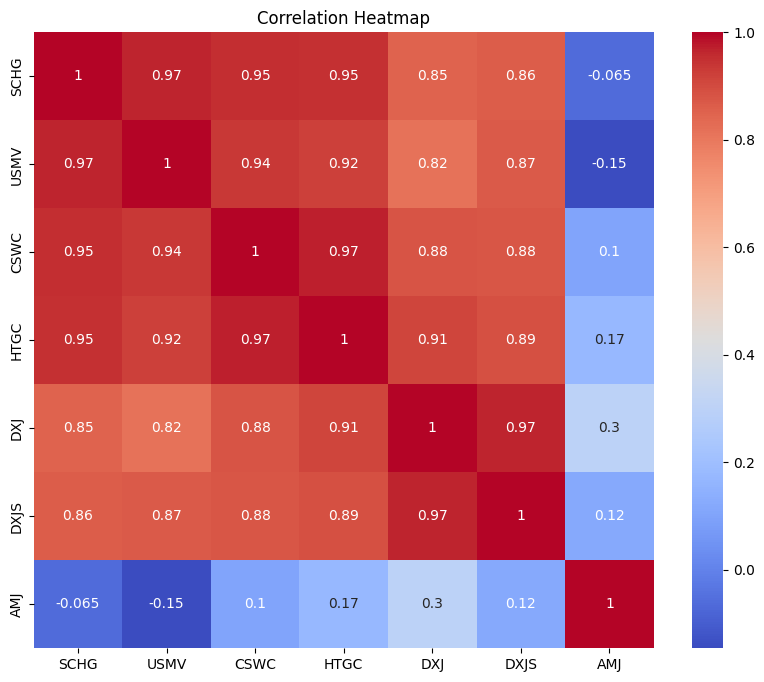

In [60]:
# Show correlation matrix for Scipy Max Sharpe Scenarios
scipy_max_sharpe_corr_matrix = df.loc[:, scipy_max_sharpe_securities].corr()

# Set the figure size
plt.figure(figsize=(10, 8))

# Create a heatmap using the correlation matrix
sns.heatmap(scipy_max_sharpe_corr_matrix, annot=True, cmap='coolwarm')

# Set the title of the plot
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

### Show portfolio weights for the Scipy Max Sharpe scenario

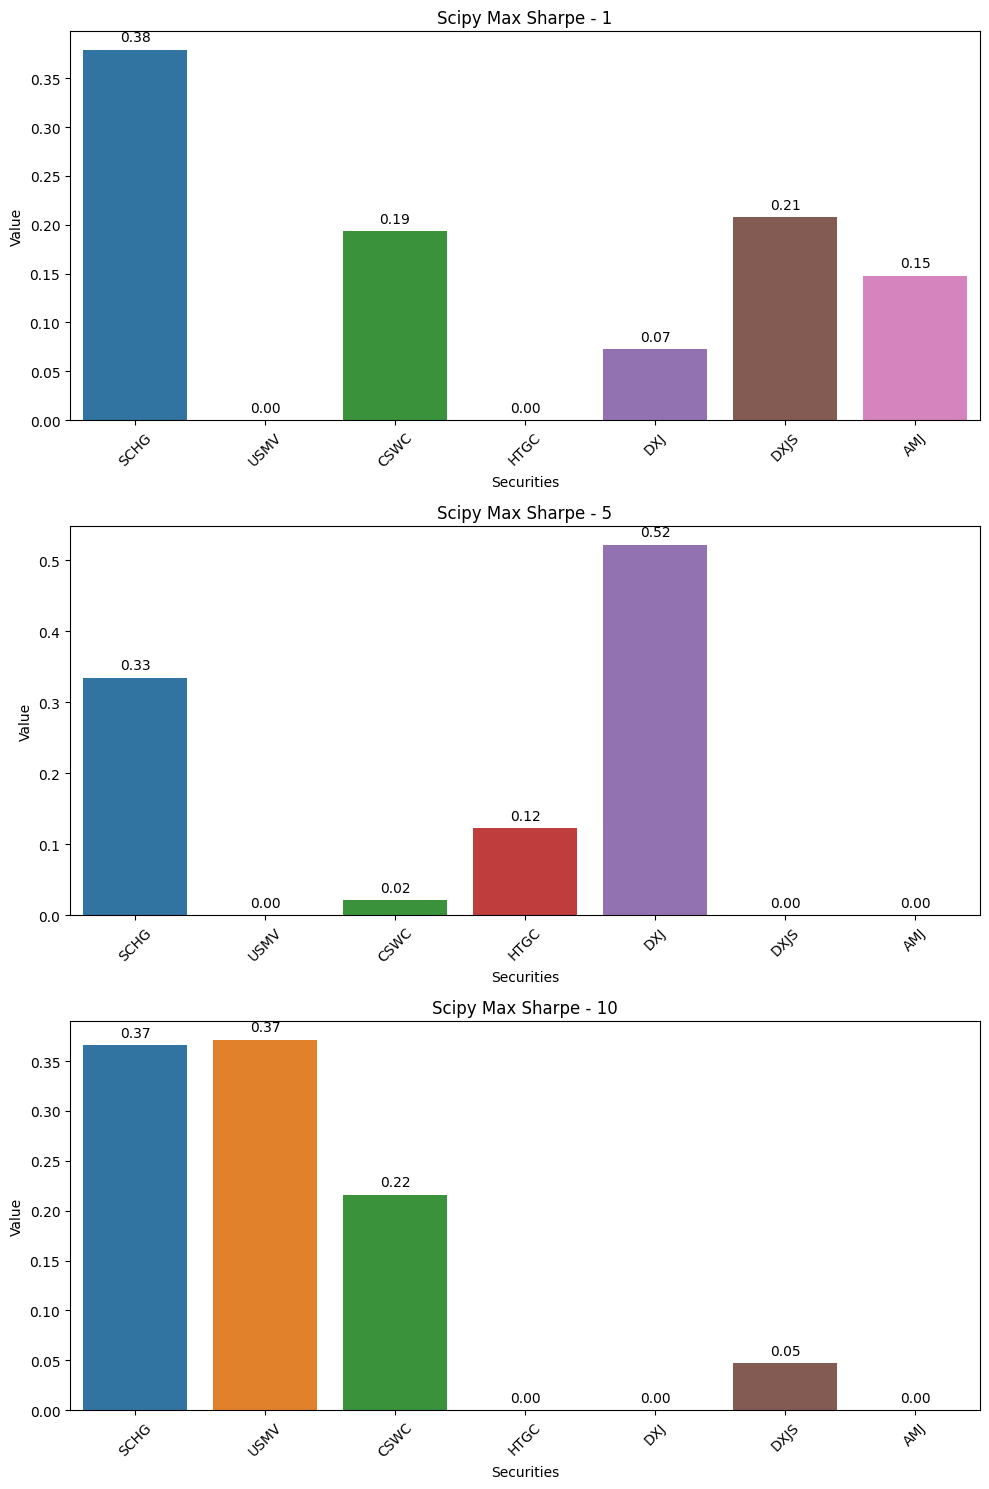

In [61]:
# Filter the dataframe for the 'Scipy Max Sharpe' scenario
scipy_max_sharpe_df = df_portfolio_metrics_scenarios[df_portfolio_metrics_scenarios['Scenario'] == 'Scipy Max Sharpe']

# Set up the matplotlib figure
fig, axes = plt.subplots(len(periods), 1, figsize=(10, 5 * len(periods)))

# Check if there is only one period, to avoid indexing issues
if len(periods) == 1:
    axes = [axes]

for i, period in enumerate(periods):
    # Filter the dataframe for the current period
    period_df = scipy_max_sharpe_df[scipy_max_sharpe_df['Period'] == period]
    
    # Select only the securities columns for the current period
    securities_df = period_df.loc[:, scipy_max_sharpe_securities]
    
    # Plot
    ax = sns.barplot(data=securities_df, ax=axes[i])
    axes[i].set_title(f'Scipy Max Sharpe - {period}')
    axes[i].set_ylabel('Value')
    axes[i].set_xlabel('Securities')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add labels on top of the bars
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

plt.tight_layout()
plt.show()